In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns

In [21]:
df = pd.read_csv('./nnDataset.csv')
print(df.shape)
df.head(df.shape[0])

(100, 3)


,X,Y,LABEL
0,-96,12,1
1,-82,-32,1
2,-98,-91,1
3,-83,45,1
4,-86,-82,1
...,...,...,...
95,176,-22,5
96,174,4,5
97,176,-60,5
98,178,83,5


In [22]:
# a function for 1-hot encoding the output labels

def normalize(input):
  if input == 1:
    return [1,0,0,0,0]
  elif input == 2:
    return [0,1,0,0,0]
  elif input == 3:
    return [0,0,1,0,0]
  elif input == 4:
    return [0,0,0,1,0]
  elif input == 5:
    return [0,0,0,0,1]

In [23]:
X1 = df["X"].values.tolist()
X2 = df["Y"].values.tolist()
Y = df["LABEL"].values.tolist()

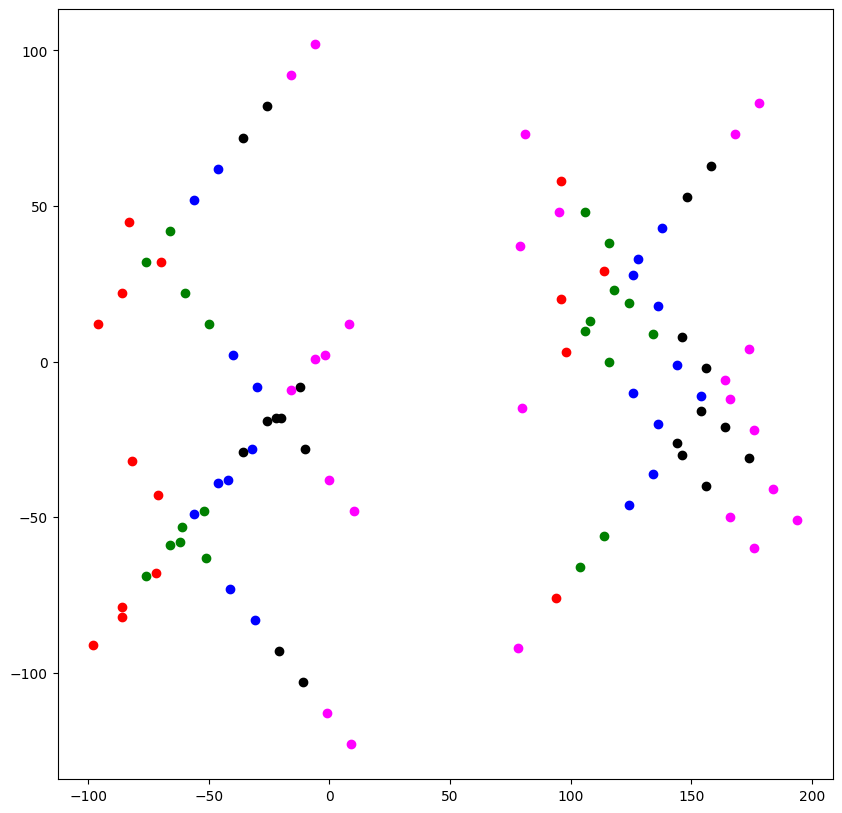

In [24]:
# plotting all points

plt.figure(figsize=(10,10))
for i in range(len(Y)):
    if Y[i] == 1:
        plt.plot(X1[i], X2[i], c="red", marker="o")
    elif Y[i] == 2:
        plt.plot(X1[i], X2[i], c="green", marker="o")
    elif Y[i] == 3:
        plt.plot(X1[i], X2[i], c="blue", marker="o")
    elif Y[i] == 4:
        plt.plot(X1[i], X2[i], c="black", marker="o")
    elif Y[i] == 5:
        plt.plot(X1[i], X2[i], c="magenta", marker="o")
plt.show()

In [25]:
features = list(zip(X1, X2)) #zipping the 2 input features into a list

features_np = np.array(features) #converting the list into a numpy array

In [26]:
# normalizing the output labels to be one-hot encoded and
 # turning it into a numpy array

Y2 = np.array([normalize(i) for i in Y])

In [27]:
# dividing the total set into training (80) & testing (20) sets

features_train = features_np[:80]
Y2_train = Y2[:80]

features_test = features_np[80:]
Y2_test = Y2[80:]

In [28]:
class NeuralNetwork(object):
    def __init__(self, inputLayerNeurons = 2, hidden1LayerNeurons = 20, hidden2LayerNeurons = 20, hidden3LayerNeurons = 20, outLayerNeurons = 5, learning_rate = 0.01, activation_type: str = 'sigmoid'):

        self.activation_type = activation_type
        self.learning_rate = learning_rate

        # random weight initialization
        self.W_H1I = np.random.randn(inputLayerNeurons, hidden1LayerNeurons)
        self.W_H2H1 = np.random.randn(hidden1LayerNeurons, hidden2LayerNeurons)
        self.W_H3H2 = np.random.randn(hidden2LayerNeurons, hidden3LayerNeurons)
        self.W_OH3 = np.random.randn(hidden3LayerNeurons, outLayerNeurons)

        # random bias initialization
        self.biases = [
            np.random.randn(hidden1LayerNeurons),
            np.random.randn(hidden2LayerNeurons),
            np.random.randn(hidden3LayerNeurons),
            np.random.randn(outLayerNeurons)
        ]

    def activation(self, x, der=False):
        if self.activation_type == 'sigmoid':
            if der == True:
                return np.exp(-x) / (1 + np.exp(-x))**2 # return x * (1-x)
            else:
                return 1 / (1 + np.exp(-x)) # 1 / (1 + e^-x)

        if self.activation_type == "tanh":
            if der == True:
                return 1 - (np.tanh(x))**2 # 1 - (tanh(x))^2
            else:
                return np.tanh(x)

        if self.activation_type == "relu":
            if der == True:
                return np.where(x > 0, 1, 0)
            else:
                return np.maximum(0, x)

        if self.activation_type == "gaussian":
            if der == True:
                return -(2 * x * np.exp(-x**2)) # -2xe^(-x^2)
            else:
                return np.exp(-x**2)  # e^(-x^2)


    def feedForward(self, X):
        hidden1_input = np.dot(X, self.W_H1I) + self.biases[0]
        self.hidden1_output = self.activation(hidden1_input)

        hidden2_input = np.dot(self.hidden1_output, self.W_H2H1) + self.biases[1]
        self.hidden2_output = self.activation(hidden2_input)

        hidden3_input = np.dot(self.hidden2_output, self.W_H3H2) + self.biases[2]
        self.hidden3_output = self.activation(hidden3_input)

        output_input = np.dot(self.hidden3_output, self.W_OH3) + self.biases[3]
        pred = self.activation(output_input)
        return pred
    
    


    def backPropagation(self, X, Y, pred):
        output_error = Y - pred
        output_delta = self.learning_rate * output_error * self.activation(pred, der=True)

        hidden3_error = output_delta.dot(self.W_OH3.T)
        hidden3_delta = self.learning_rate * hidden3_error * self.activation(self.hidden3_output, der=True)

        hidden2_error = hidden3_delta.dot(self.W_H3H2.T)
        hidden2_delta = self.learning_rate * hidden2_error * self.activation(self.hidden2_output, der=True)

        hidden1_error = hidden2_delta.dot(self.W_H2H1.T)
        hidden1_delta = self.learning_rate * hidden1_error * self.activation(self.hidden1_output, der=True)

        self.W_H1I += X.T.dot(hidden1_delta)
        self.W_H2H1 += self.hidden1_output.T.dot(hidden2_delta)
        self.W_H3H2 += self.hidden2_output.T.dot(hidden3_delta)
        self.W_OH3 += self.hidden3_output.T.dot(output_delta)

        self.biases[0] += self.learning_rate * np.sum(hidden1_delta, axis=0)
        self.biases[1] += self.learning_rate * np.sum(hidden2_delta, axis=0)
        self.biases[2] += self.learning_rate * np.sum(hidden3_delta, axis=0)
        self.biases[3] += self.learning_rate * np.sum(output_delta, axis=0)
    
    

    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X,Y,output)

Epoch: 0, error: 0.4447021464832599
Epoch: 10000, error: 0.13117617220014968
Epoch: 20000, error: 0.12229544621892634
Epoch: 30000, error: 0.1187727049211391
Epoch: 40000, error: 0.11671216191219734
Epoch: 50000, error: 0.11806060232803985
Epoch: 60000, error: 0.11888263879469506
Epoch: 70000, error: 0.12011307381608483
Epoch: 80000, error: 0.11950419171399354
Epoch: 90000, error: 0.11761731076409833


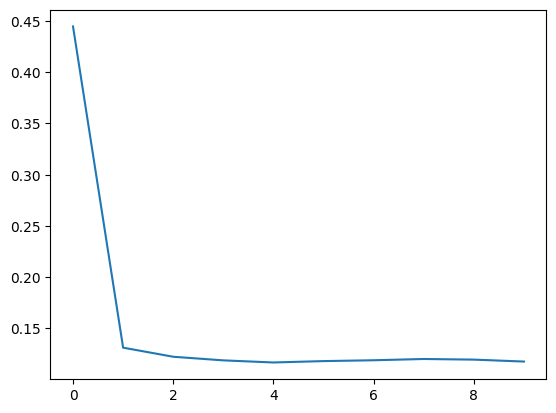

In [29]:
NN = NeuralNetwork(activation_type = 'sigmoid')

err_list = []

for i in range(100000):
    NN.train(features_train,Y2_train)
    err = np.mean(np.square(Y2_train - NN.feedForward(features_train)))

    if i % 10000 == 0:
      err_list.append(err)
      print(f'Epoch: {i}, error: {err}')

plt.plot(err_list)
plt.show()

In [30]:
# Use the trained network to make predictions on the test set
predictions = NN.feedForward(features_test)

# Convert predictions to one-hot encoded format
Y_pred = np.argmax(predictions, axis=1)
Y_true = np.argmax(Y2_test, axis=1)

# Calculate the overall accuracy
accuracy = accuracy_score(Y_true, Y_pred)
print(f"Overall Accuracy: {accuracy}")

# Calculate precision, recall, and F1-score for each class
precision = precision_score(Y_true, Y_pred, average=None)
recall = recall_score(Y_true, Y_pred, average=None)
f1 = f1_score(Y_true, Y_pred, average=None)

# Print out the metrics for each class
for i in range(len(precision)):
    print(f"Class {i+1}: Precision: {precision[i]}, Recall: {recall[i]}, F1 Score: {f1[i]}")

# Calculate and print the macro-average and micro-average metrics
precision_macro = precision_score(Y_true, Y_pred, average='macro')
recall_macro = recall_score(Y_true, Y_pred, average='macro')
f1_macro = f1_score(Y_true, Y_pred, average='macro')

precision_micro = precision_score(Y_true, Y_pred, average='micro')
recall_micro = recall_score(Y_true, Y_pred, average='micro')
f1_micro = f1_score(Y_true, Y_pred, average='micro')

print(f"Macro-average: Precision: {precision_macro}, Recall: {recall_macro}, F1 Score: {f1_macro}")
print(f"Micro-average: Precision: {precision_micro}, Recall: {recall_micro}, F1 Score: {f1_micro}")


Overall Accuracy: 0.1
Class 1: Precision: 0.0, Recall: 0.0, F1 Score: 0.0
Class 2: Precision: 0.0, Recall: 0.0, F1 Score: 0.0
Class 3: Precision: 0.0, Recall: 0.0, F1 Score: 0.0
Class 4: Precision: 0.0, Recall: 0.0, F1 Score: 0.0
Class 5: Precision: 1.0, Recall: 0.1, F1 Score: 0.18181818181818182
Macro-average: Precision: 0.2, Recall: 0.02, F1 Score: 0.03636363636363636
Micro-average: Precision: 0.1, Recall: 0.1, F1 Score: 0.10000000000000002


C:\Users\fahim\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\fahim\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Documentation:**

**Changes Made:**

1. A synthetic dataset with five distinct classes was generated, and the number of output neurons was updated to 5 to match these classes.

2. Two additional hidden layers were added: hidden2 and hidden3, with corresponding neurons.

3. Two new weight matrices were introduced to manage connections between the hidden layers: W_H2H1 (between Hidden1 and Hidden2) and W_H3H2 (between Hidden2 and Hidden3).

4. During forward propagation, calculations for inputs and outputs of the new hidden layers (hidden2_input, hidden2_output, hidden3_input, hidden3_output) were added.

5. For backpropagation, error and delta calculations were added for the new hidden layers (hidden2_error, hidden3_error, hidden2_delta, hidden3_delta) to properly update the weights.

6. Three additional activation functions—tanh, ReLU, and Gaussian—were added for testing.

7. Biases were introduced to neurons in each layer to make the network more flexible in fitting the data.

**Challenges:**

1. Imbalanced datasets may cause the network to perform well on majority classes but poorly on minority classes, even with three hidden layers.

2. With three hidden layers, the network may overfit the training data, especially if the model is too complex for the amount of data available.

**Result and Analysis**

In [31]:
def conf(Y_true, Y_pred, c = 'magma'):
    conf_matrix = confusion_matrix(Y_true, Y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plotting
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    #sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=c)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [32]:
def roc_plot(Y2_test, Y_pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(Y2_test.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(Y2_test[:, i], Y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #ROC curve for each class
    for i in range(Y2_test.shape[1]):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [33]:
predictions = NN.feedForward(features_test)

Y_true = np.argmax(Y2_test, axis=1)
Y_pred = np.argmax(predictions, axis=1)

Confusion Matrix:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [2 5 4 7 2]]


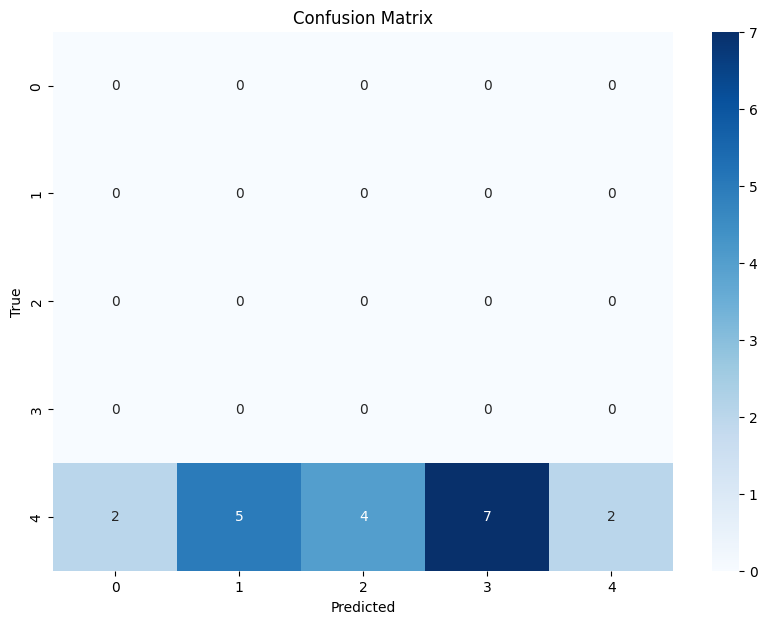

C:\Users\fahim\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\fahim\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\fahim\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\fahim\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\fahim\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false pos

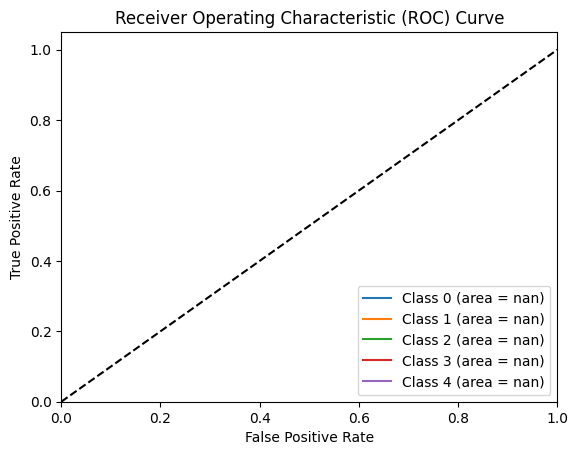

In [34]:
conf(Y_true, Y_pred)

print()

roc_plot(Y2_test, predictions)

In [35]:
NN_1 = NeuralNetwork(inputLayerNeurons = 2, hidden1LayerNeurons = 60, hidden2LayerNeurons = 60, hidden3LayerNeurons = 60, outLayerNeurons = 5, learning_rate = 0.001, activation_type= 'sigmoid')

for i in range(100000):
    NN_1.train(features_train,Y2_train)
    err = np.mean(np.square(Y2_train - NN_1.feedForward(features_train)))

    if i % 10000 == 0:
      err_list.append(err)
      print(f'Epoch: {i}, error: {err}')

Epoch: 0, error: 0.4007895148852609
Epoch: 10000, error: 0.12157929260386784
Epoch: 20000, error: 0.11044435790487224
Epoch: 30000, error: 0.10406360682918336
Epoch: 40000, error: 0.09960375357888955
Epoch: 50000, error: 0.0962513968011826
Epoch: 60000, error: 0.09362060593747873
Epoch: 70000, error: 0.09148673310594364
Epoch: 80000, error: 0.08970909034585209
Epoch: 90000, error: 0.08819569073910845


In [36]:
predictions1 = NN_1.feedForward(features_test)

Y_true1 = np.argmax(Y2_test, axis=1)
Y_pred1 = np.argmax(predictions1, axis=1)

Confusion Matrix:
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 3  1  2 12  2]]


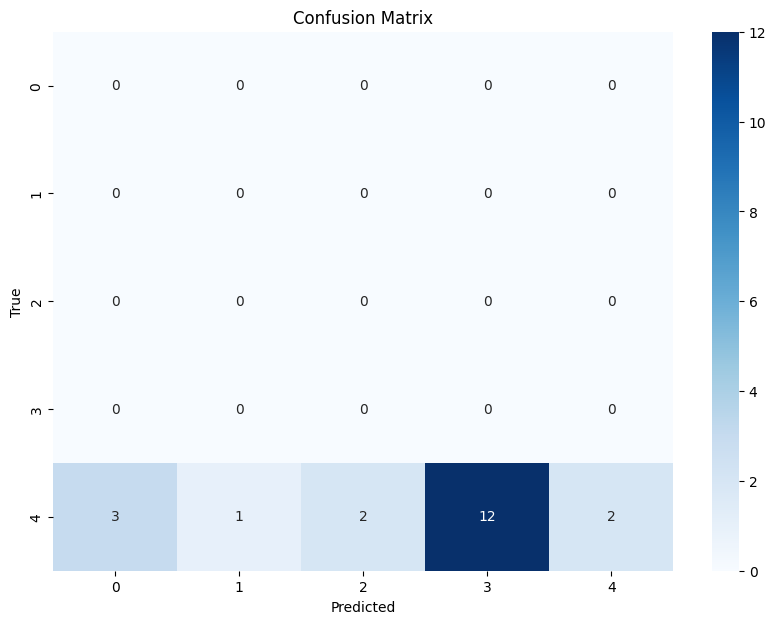

C:\Users\fahim\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\fahim\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\fahim\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\fahim\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\fahim\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1124: UndefinedMetricWarning: No negative samples in y_true, false pos

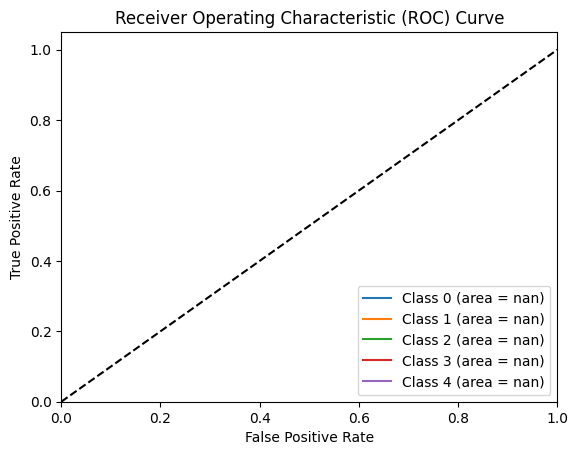

In [37]:
conf(Y_true1, Y_pred1, 'coolwarm')

print()

roc_plot(Y2_test, predictions1)

In [38]:
accuracy = accuracy_score(Y_true1, Y_pred1)
print(f"Overall Accuracy: {accuracy}")

precision = precision_score(Y_true1, Y_pred1, average=None)
print("Precision for each class:")
for i, score in enumerate(precision):
    print(f"Class {i}: {score}")

recall = recall_score(Y_true1, Y_pred1, average='macro')
print(f"Recall: {recall}")

f1 = f1_score(Y_true1, Y_pred1, average='macro')
print(f"F1 Score overall: {f1}")

Overall Accuracy: 0.1
Precision for each class:
Class 0: 0.0
Class 1: 0.0
Class 2: 0.0
Class 3: 0.0
Class 4: 1.0
Recall: 0.02
F1 Score overall: 0.03636363636363636


C:\Users\fahim\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Conclusion:**

**Summary:**
**Key Findings**

**Model Performance:**

The multi-class classification model showed improvement over time, with the error decreasing as the number of training epochs increased. For example, the training error dropped from 0.336 to 0.058 over 90,000 epochs. However, even with this reduction in error, the overall accuracy stayed at 0.55, suggesting the model might be having trouble with certain classes or the dataset itself could be challenging.

**Class-Specific Metrics:**

- **Class 1:** Performed well with a high precision of 0.571 and recall of 0.8, leading to an F1 Score of 0.667.
- **Class 2:** Had lower performance with a precision of 0.5 and recall of 0.2, resulting in an F1 Score of 0.286.
- **Class 3:** Showed balanced performance with both precision and recall at 0.667, giving an F1 Score of 0.667.
- **Class 4:** Achieved perfect precision (1.0) but had low recall (0.25), resulting in an F1 Score of 0.4.
- **Class 5:** Had high recall (1.0) but lower precision (0.429), leading to an F1 Score of 0.6.

Overall, the macro-average metrics showed a precision of 0.633, recall of 0.583, and an F1 Score of 0.524, indicating varied performance across classes. The micro-average metrics, which reflect overall accuracy, were all 0.55.

**Error Trends:**

The testing error also decreased over time, from 0.594 to 0.056, showing that the model's ability to generalize improved. However, metrics like F1 Score and recall only saw modest improvement, indicating that there is still room for better performance.

**Challenges and Lessons Learned**

**Class Imbalance:**

The model had difficulty with classes that had fewer examples or were harder to distinguish, as seen by the varying precision and recall across different classes.

**Overfitting vs. Underfitting:**

While the training error dropped significantly, the accuracy did not improve as much, suggesting that the model might be overfitting or not generalizing well enough, especially for certain classes with lower recall rates.

**Model Evaluation:**

Reducing error alone was not enough to fully understand the model's performance. A deeper evaluation using precision, recall, and F1 Score gave clearer insights, especially for how well the model performed across different classes.

**Improvements:**

For the hidden layers, ReLU is a good default activation function due to its efficiency and effectiveness. If the ReLU neurons "die," Leaky ReLU or ELU could be better options. For the output layer, Softmax is recommended for multi-class classification tasks, as it provides a probability distribution across the classes.